In [1]:
from projectq import MainEngine
# from projectq.backends import CircuitDrawerMatplotlib, CommandPrinter
# from projectq.setups.default import get_engine_list

# drawer_engine = CircuitDrawerMatplotlib()
# printer_engine = CommandPrinter()
eng = MainEngine()

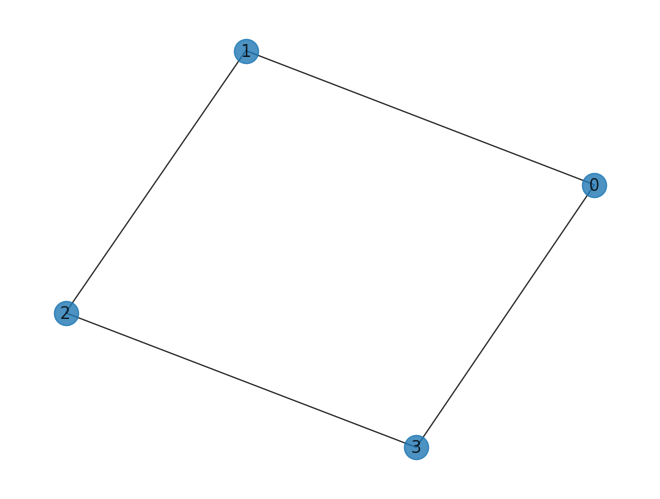

In [2]:
import networkx as nx
from networkx import Graph

g = Graph()
nodes = eng.allocate_qureg(4)
edges = [(nodes[i], nodes[(i+1) % 4]) for i in range(4)]
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.draw(g, with_labels=True, alpha=0.8, node_size=300)

In [3]:
from projectq.ops import Rx

def mixer(g: Graph, beta: float):
    for n in g:
        Rx(2*beta) | n

In [4]:
from projectq.ops import Rzz, CNOT

def problem(g: Graph, gamma: float):
    for i, j in g.edges():
        Rzz(2*gamma) | (i, j)
        # CNOT | (i, j)

In [5]:
from functools import reduce
from projectq.ops import All, H, Measure, X

def sample_circuit(g: Graph, beta: float, gamma: float):
    qubits = list(g.nodes())
    All(H) | qubits
    for _ in range(2):
        problem(g, gamma)
        mixer(g, beta)
    All(Measure) | qubits
    eng.flush()

    result = reduce(lambda a, b: a + b, map(lambda x: str(int(x)), g.nodes()))

    for n in g:
        if int(n):
            X | n

    return result

In [6]:
def maxcut_obj(x: str, g: Graph):
    return reduce(lambda obj, e: obj - (1 if x[e[0].id] != x[e[1].id] else 0), g.edges(), 0)

In [7]:
# result = sample_circuit(g, 1.0, 1.0)
# print(result)
# print(maxcut_obj(result, g))

result = sample_circuit(g, 0.5, 0.5)
print(result)
print(maxcut_obj(result, g))

# with open("test.tex", "w") as file:
#     file.write(backend.get_latex())
# drawer_engine.draw()

1111
0


In [8]:
from collections import Counter

def compute_expectation(cuts: Counter, g: Graph):
    sum, count = reduce(lambda t, c: (t[0] + (maxcut_obj(c, g) * cuts[c]), t[1] + cuts[c]), cuts, (0, 0))
    return sum / count

In [9]:
def get_expectation(g: Graph, shots=512):
    def execute_circ(params: list[float]):
        counter = {}
        for _ in range(shots):
            result = sample_circuit(g, params[0], params[1])
            counter[result] = counter.get(result, 0) + 1
        return compute_expectation(Counter(counter), g)

    return execute_circ

In [10]:
from scipy.optimize import minimize

expectation = get_expectation(g)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -3.9453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.09071116, 1.07243674])

<BarContainer object of 8 artists>

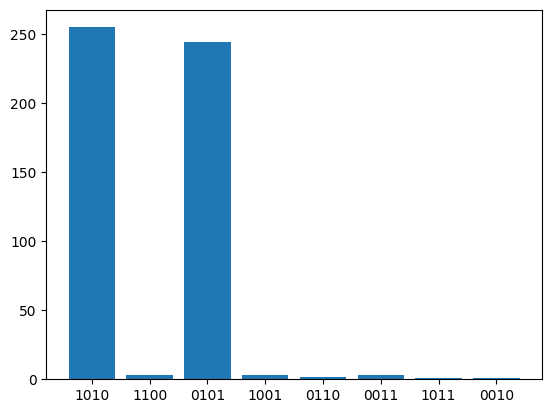

In [16]:
import matplotlib.pyplot as plt

counter = {}
for _ in range(512):
    result = sample_circuit(g, res.x[0], res.x[1])
    counter[result] = counter.get(result, 0) + 1

c = Counter(counter)

plt.bar(c.keys(), c.values())